# Lab 3 Analysis

In [47]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import scipy

In [48]:
import astropy.constants as con
import astropy.units as u
import scipy.special
import scipy.signal
import matplotlib.cm as cm
# import ugradio

In [190]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.linewidth'] = 1

## Baseline Analysis (1hr Sun Obs)

In [835]:
sun_data_1hr, sun_times_1hr = np.load('data/1hr_Sun_data.npy')
sun_data_1hr = sun_data_1hr[50:]
sun_times_1hr = sun_times_1hr[50:]

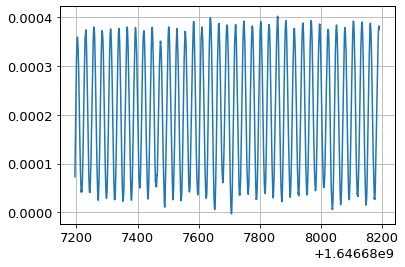

In [836]:
plt.plot(sun_times_1hr[:5000], sun_data_1hr[:5000])

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


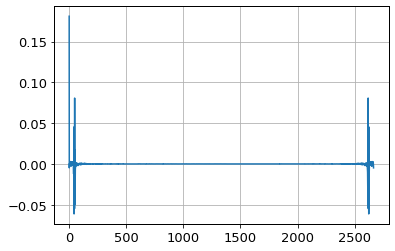

In [837]:
n = len(sun_data)
beginning, beginning_time = sun_data[:n//3], sun_times[:n//3]
middle, middle_time = sun_data[n//3:2*n//3], sun_times[n//3:2*n//3]
end, end_time = sun_data[2*n//3:], sun_times[2*n//3:]
beginning_fft = np.fft.fft(beginning)
plt.plot(beginning_fft)

In [838]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr, dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr), dt))

In [839]:
def split_data(data, time, num_splits):
    n = len(data)
    split_size = n // num_splits
    data_splits = []
    freq_splits = []
    for i in range(num_splits):
        data_frac = data[i*split_size:(i+1)*split_size]
        time_frac = time[i*split_size:(i+1)*split_size]
        dt = np.mean(np.diff(time_frac))
        frequency = freq(time_frac, dt)
        pow_frac = pow_fft(data_frac)
        
        data_splits.append(pow_frac)
        freq_splits.append(frequency)
        
    return data_splits, freq_splits

Text(0.5, 1.0, 'Sun 3 Split Power Spectra')

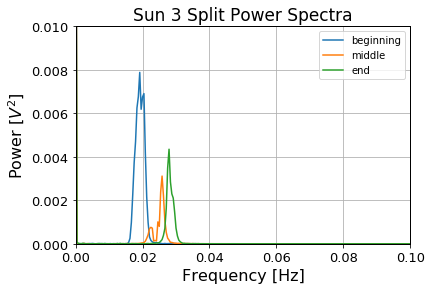

In [840]:
# dt = np.mean(np.diff(sun_times))
# beginning_freq = freq(beginning_time, dt)
# middle_freq = freq(middle_time, dt)
# end_freq = freq(end_time, dt)

# pow_beginning = pow_fft(beginning)
# pow_middle = pow_fft(middle) 
# pow_end = pow_fft(end) 
sun_data_split, sun_time_split = split_data(sun_data, sun_times, 3)
pow_beginning, pow_middle, pow_end = sun_data_split
beginning_freq, middle_freq, end_freq = sun_time_split

plt.plot(beginning_freq, pow_beginning, label="beginning")
plt.plot(middle_freq, pow_middle, label='middle')
plt.plot(end_freq, pow_end, label='end')
plt.legend()
# plt.xlim(0.03,0.04)
plt.xlim(0.0,0.1)
# plt.yscale('log')
plt.ylim(0,0.01)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [$V^2$]')
plt.title('Sun 3 Split Power Spectra')

# should be power squared arbitrary units

32 32


Text(0, 0.5, 'Frequency [Hz]')

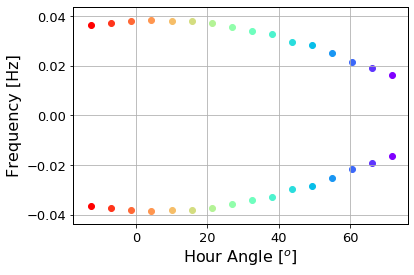

In [841]:
print(len(ha_peaks), len(peaks))
ha_peaks_degrees = [ha * 180 / np.pi if ha *180 / np.pi < 270 else 360 - ha *180 / np.pi for ha in ha_peaks]
for i in range(len(colors)):
    plt.scatter(ha_peaks_degrees[i*2], peaks[i*2], color=colors[i])
    plt.scatter(ha_peaks_degrees[i*2+1], peaks[i*2+1], color=colors[i])
plt.xlabel('Hour Angle [$ ^o$]')
plt.ylabel('Frequency [Hz]')

In [842]:
moon_data, moon_times = np.load('data/moon.npy')

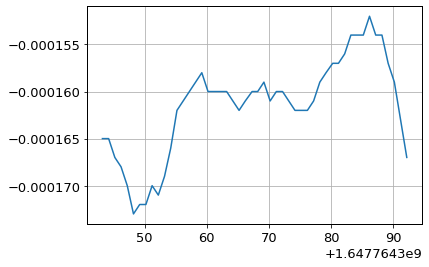

In [843]:
plt.plot(moon_times[:50], moon_data[:50])

Text(0.5, 1.0, 'Split Power Spectra')

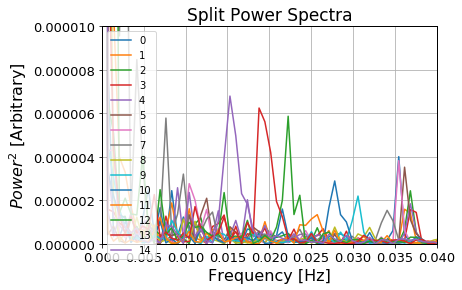

In [844]:
moon_splits, moon_freqs = split_data(moon_data, moon_times, 15)
for i in range(len(moon_splits)):
#     crab_splits[i][len(crab_splits[i])//2-1000:len(crab_splits[i])//2+1000] = 0
    plt.plot(moon_freqs[i], moon_splits[i], label=str(i))
plt.legend(loc='upper left')
plt.xlim(0,0.04)
plt.ylim(0,.00001)
# plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('$Power^2$ [Arbitrary]')
plt.title('Split Power Spectra')

In [845]:
#model functions
def vTg(ha, B_ew, B_ns, delta, lambd):
    return (((B_ew / lambd) * np.cos(delta)) * np.sin(ha) + ((B_ns / lambd) * np.sin(L) * np.cos(delta)) * np.cos(ha))

def fringe_model(vTg, A, B):
    return A * np.cos(2 * np.pi * vTg) + B * np.sin(2 * np.pi * vTg)


In [846]:
delta = -0.08984633843061296
lambd = 0.02855166266666667
ha = np.load('ha_sun_1hr.npy')
ha = ha[50:]
L = 37.873199

Text(0, 0.5, 'Jansky [Arbitrary]')

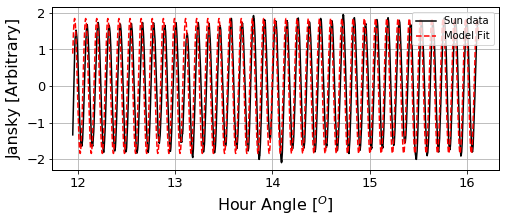

In [848]:
plt.figure(figsize=(8, 3))
v = vTg(ha, 14.8035, 2.0898, delta, lambd)
ha_degrees = [h * 180 / np.pi if h *180 / np.pi < 270 else 360 - h *180 / np.pi for h in ha]
plt.plot(ha_degrees[:5000],(sun_data_1hr[:5000]-np.mean(sun_data_1hr[:5000]))*1e4, color='black',label='Sun data')
plt.plot(ha_degrees[:5000], fringe_model(v, -0.00014, 0.00012)[:5000]*1e4, color='red', ls='--', label='Model Fit')
plt.legend(loc="upper right")
plt.xlabel("Hour Angle [$^O$]")
plt.ylabel('Jansky [Arbitrary]')

In [764]:
#create grid of baseline values
resolution = 100
xmin,xmax = 14.8025, 14.8045
ymin,ymax = 2.06, 2.11
B_ew, B_ns = np.linspace(xmin, xmax, resolution), np.linspace(ymin, ymax, resolution)
B_EW, B_NS = np.meshgrid(B_ew, B_ns)

In [765]:
def compute_χ_sq(file_name):
    ydata = sun_data_1hr - np.mean(sun_data_1hr)

    χ_sq = np.zeros(B_EW.shape)
    χ_sq_r = np.zeros(B_EW.shape)
    
    for i in range(len(B_ew)):
        for j in range(len(B_ns)):
            vs = vTg(ha, B_EW[i,j], B_NS[i,j], delta, lambd)  # Try new baselines
            p0 = np.array([0.0002,0.0003]) # A, B Guesses
            params, cov = scipy.optimize.curve_fit(fringe_model, vs, ydata, p0)
            chi_squared = np.sum(((fringe_model(vs, *params)-ydata)/.00002)**2)
            reduced_chi_squared = (chi_squared)/(len(vs)-len(params))
            χ_sq[i,j] = chi_squared
            χ_sq_r[i,j] = reduced_chi_squared
            
    np.save("data/chi_sq_" + file_name + ".npy", χ_sq)
    np.save("data/chi_sq_r_" + file_name + ".npy", χ_sq_r)
    
    return χ_sq, χ_sq_r

In [766]:
χ_sq, χ_sq_r = compute_χ_sq("1hr_sun_zoomed_in")

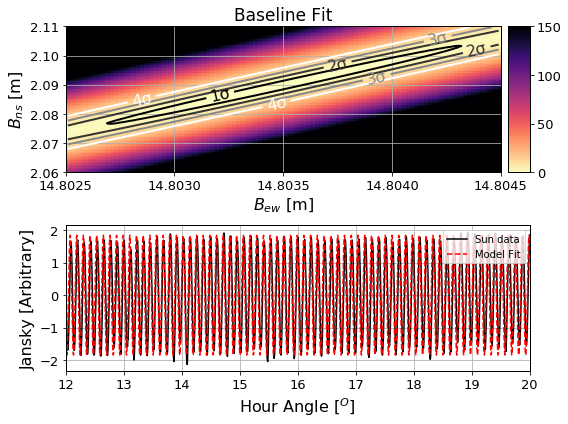

In [867]:
# χ_sq_R = np.load("data/chi_sq_r_6hr_sun.npy")
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(2, 1, figsize=(8,6))

ax = axs[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)

# im = ax.imshow(data, cmap='bone')

extent=[xmin, xmax, ymin, ymax]
levels = [1, 4, 9, 16]
# plt.figure(figsize=(8,3))
ax.set_title("Baseline Fit")

fmt = {}
strs = ['1σ', '2σ', '3σ', '4σ']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
    
cs = ax.contour(χ_sq - np.min(χ_sq), levels, cmap='gray', origin='lower',linewidths=2, extent=extent)
im = ax.imshow(χ_sq - np.min(χ_sq), origin="lower",extent=extent, cmap = 'magma_r',aspect="auto", vmax=150)
ax.set_xlabel("$B_{ew}$ [m]")
ax.set_ylabel("$B_{ns}$ [m]")
# plt.ylim(3.23,3.28)
# plt.xlim(14.,14.705)
# print(χ_sq - np.min(χ_sq))
fig.colorbar(im, cax=cax, orientation='vertical')
ax.clabel(cs, cs.levels, fmt = fmt, inline=1, fontsize=16)  
ax.set_xticks([14.8025, 14.8030, 14.8035, 14.804, 14.8045])
ax.set_xticklabels(['14.8025','14.8030', '14.8035', '14.8040', '14.8045'])

# plt.figure(figsize=(8, 3))
ax = axs[1]
v = vTg(ha, 14.8035, 2.0898, delta, lambd)
ha_degrees = [h * 180 / np.pi if h *180 / np.pi < 270 else 360 - h *180 / np.pi for h in ha]
ax.plot(ha_degrees[:10000],(sun_data_1hr[:10000]-np.mean(sun_data_1hr[:10000]))*1e4, color='black',label='Sun data')
ax.plot(ha_degrees[:10000], fringe_model(v, -0.00014, 0.00012)[:10000]*1e4, color='red', ls='--', label='Model Fit')
ax.legend(loc="upper right")
ax.set_xlabel("Hour Angle [$^O$]")
ax.set_ylabel('Jansky [Arbitrary]')
ax.set_xlim(12, 20)
plt.tight_layout()

In [784]:
shifted = χ_sq - np.min(χ_sq) 

nσ = 2

xs = np.where(np.isclose(shifted, nσ**2, rtol=1e-2))[0][:]
ys = np.where(np.isclose(shifted, nσ**2, rtol=1e-2))[1][:]

max_B_ew, min_B_ew = np.max(B_EW[xs,ys]),np.min(B_EW[xs,ys])
max_B_ns, min_B_ns = np.max(B_NS[xs,ys]),np.min(B_NS[xs,ys])

bf_B_ew = B_EW[np.where(shifted == np.min(shifted))][0]
bf_B_ns = B_NS[np.where(shifted == np.min(shifted))][0]

print("The North-South Baseline is {0:0.4f} + {1:0.4f} - {2:0.4f} [m] to {3}σ".format(bf_B_ns, 
                                                                              max_B_ns - bf_B_ns, 
                                                                              bf_B_ns - min_B_ns, nσ))

print("The East-West Baseline is {0:0.4f} + {1:0.4f} - {2:0.4f} [m] to {3}σ".format(bf_B_ew, 
                                                                              max_B_ew - bf_B_ew, 
                                                                              bf_B_ew - min_B_ew, nσ))

The North-South Baseline is 2.0898 + 0.0141 - 0.0187 [m] to 2σ
The East-West Baseline is 14.8035 + 0.0010 - 0.0010 [m] to 2σ


In [785]:
χ_sq_final_r_bf = np.max(χ_sq / (len(ha) - 2))
print(f"We report a reduced χ^2 value for the best fit of {χ_sq_final_r_bf}")

We report a reduced χ^2 value for the best fit of 3.201182322697399


## Analyzing Sun Diameter (First 6hr Obs)

23964 1647962845.7619097 1647984412.4624336


(-18, 72)

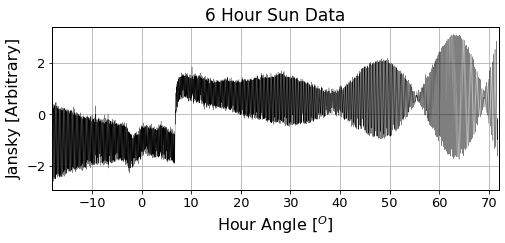

In [812]:
plt.figure(figsize=(8,3))
sun_data, sun_times = np.load('data/sun_6hr.npy')
ha = np.load('ha_sun_6hr.npy')
# ha_degrees = [h * 180 / np.pi if h *180 / np.pi < 270 else 360 - h *180 / np.pi for h in ha]
ha_degrees = [h * 180 / np.pi if h *180 / np.pi < 270 else 360 - h *180 / np.pi for h in ha]
plt.xlabel('Hour Angle [$^O$]')
plt.ylabel("Jansky [Arbitrary]")
print(len(sun_times), min(sun_times), max(sun_times))
plt.plot(ha_degrees, sun_data*1e4, color='black', lw=0.25)
plt.title("6 Hour Sun Data")
plt.xlim(-18,72)

Text(264.74090909090904, 0.5, 'Frequency [Hz]')

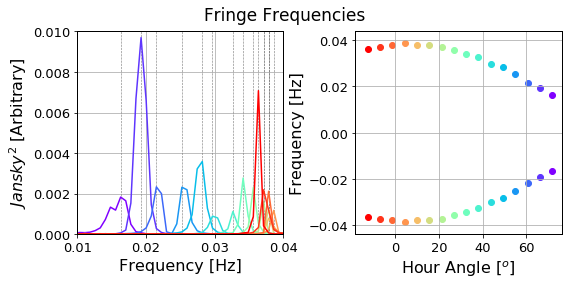

In [813]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
ax = axs[0]
sun_splits, sun_freqs = split_data(sun_data, sun_times, 16)
colors = cm.rainbow(np.linspace(0, 1, len(sun_splits)))
n = len(sun_splits)
peaks = []
ha_peaks = []
for i in range(n):
    ax.plot(sun_freqs[i], sun_splits[i], color=colors[i], label=str(ha[len(sun_splits[i]) * i] * 180/np.pi)[:5])
#     plt.plot(sun_freqs[i], sun_splits[i], color=colors[i])
    peak1, peak2 = scipy.signal.find_peaks(sun_splits[i], height=[0.0001, 0.01])[0][0], scipy.signal.find_peaks(sun_splits[i], height=[0.0001, 0.01])[0][-1]
    peaks.append(sun_freqs[i][peak2])
    peaks.append(sun_freqs[i][peak1])
    ha_peaks.append(ha[len(sun_splits[i]) * i])
    ha_peaks.append(ha[len(sun_splits[i]) * i])
#     plt.vlines(sun_freqs[i][peak1], 0, 0.01, lw=0.5)
    ax.vlines(sun_freqs[i][peak2], 0, 0.01, color='gray',lw=0.6, ls='--')
# plt.legend(loc='upper right')
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("$Jansky ^2$ [Arbitrary]")
fig.suptitle("Fringe Frequencies", fontsize=17)
# plt.title("Fringe Frequency")
ax.set_xlim(0.01,0.04)
ax.set_ylim(0,0.01)
ax.set_title(" ")

ax = axs[1]
ha_peaks_degrees = [ha * 180 / np.pi if ha *180 / np.pi < 270 else 360 - ha *180 / np.pi for ha in ha_peaks]
for i in range(len(colors)):
    ax.scatter(ha_peaks_degrees[i*2], peaks[i*2], color=colors[i])
    ax.scatter(ha_peaks_degrees[i*2+1], peaks[i*2+1], color=colors[i])
ax.set_xlabel('Hour Angle [$ ^o$]')
plt.tight_layout()
ax.set_ylabel('Frequency [Hz]')

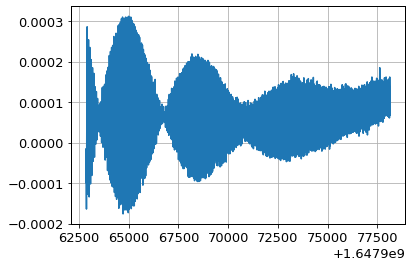

In [814]:
plt.plot(sun_times[:17000], sun_data[:17000])
sun_times, sun_data = sun_times[:17000], sun_data[:17000]
ha = ha[:17000]
ha_degrees = np.array([h * 180 / np.pi if h *180 / np.pi < 270 else 360 - h *180 / np.pi for h in ha])

# sun_data[:2000]

In [815]:
import astropy.constants as con
import astropy.units as u
import scipy.special
import scipy
# import ugradio

In [816]:
x = np.linspace(0.01,15,10000)
j1 = scipy.special.j1(x)

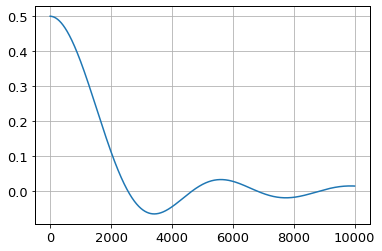

In [817]:
plt.plot(j1/x)

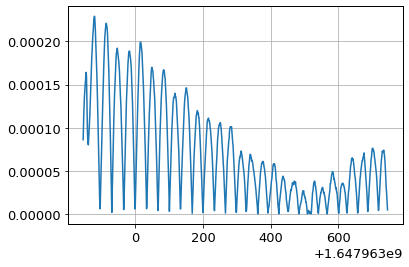

In [818]:
centered_abs_sun_data = np.abs(sun_data - np.average(sun_data))
plt.plot(sun_times[:1000], centered_abs_sun_data[:1000])

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$Jansky^2$ [Arbitrary]')

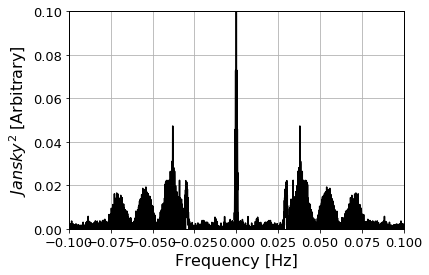

In [819]:
fft = np.fft.fftshift(np.fft.fft(centered_abs_sun_data))
freqs = freq(sun_times, np.mean(np.diff(sun_times)))
plt.plot(freqs, fft, color='black')
plt.ylim(0,.1)
plt.xlim(-0.1, 0.1)
plt.xlabel("Frequency [Hz]")
plt.ylabel("$Jansky^2$ [Arbitrary]")
# plt.vlines(0.2, 0, .2)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.0025, 0.0025)

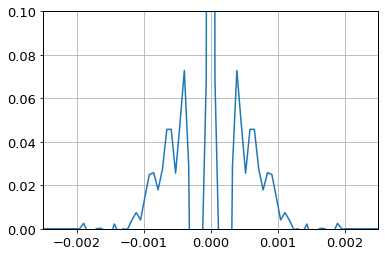

In [820]:
fft[np.where(freqs > 0.002)] = 0
fft[np.where(freqs < -0.002)] = 0
plt.plot(freqs, fft)
plt.ylim(0,0.1)
plt.xlim(-0.0025, 0.0025)

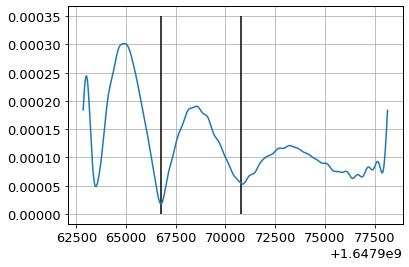

In [821]:
filtered_sun_data = np.fft.ifft(fft)


centered_abs_filtered = np.abs(filtered_sun_data - np.average(filtered_sun_data))
index = scipy.signal.argrelmin(centered_abs_filtered, order=2000)

minima = ha_degrees[index]

plt.plot(sun_times[:20000], 2*centered_abs_filtered[:20000])
# plt.plot(sun_times[:10000], (sun_data - np.median(sun_data))[:10000])
# np.where(sun_times < )
# plt.xlim(65000+1.6479e9, 72500+1.6479e9)
plt.vlines(66750+1.6479e9, 0,0.00035)
plt.vlines(70800+1.6479e9, 0, 0.00035)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


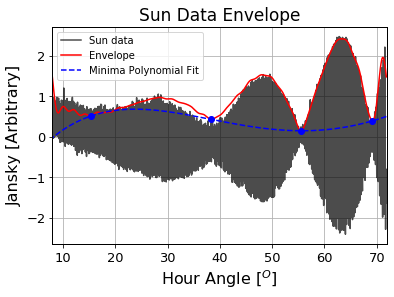

In [822]:
minima = ha_degrees[index] - ha_degrees[0]
minima_data = centered_abs_filtered[index]

plt.plot(ha_degrees, (sun_data - np.average(sun_data))*1e4, alpha=0.7, color='black', label='Sun data')
plt.plot(ha_degrees, 1.6*centered_abs_filtered*1e4, c='r', label='Envelope')
plt.scatter(minima + ha_degrees[0], 1.6*minima_data*1e4, c='blue', zorder=5)

# p1 = np.polyfit(minima, minima_data, deg=1)
# y1 = np.polyval(p1, sun_times - sun_times[0])
# plt.plot(sun_times, y1)
p2 = np.polyfit(minima, minima_data, deg=4)
y2 = np.polyval(p2, ha_degrees - ha_degrees[0])
# print(len(ha_degrees), len(y2))
plt.plot(ha_degrees, 1.6*y2*1e4, color='blue', ls='--', label='Minima Polynomial Fit')
plt.xlim(8, 72)
plt.xlabel('Hour Angle [$^O$]')
plt.ylabel('Jansky [Arbitrary]')
plt.title('Sun Data Envelope')
plt.legend()

(1647965000.0, 1647972500.0)

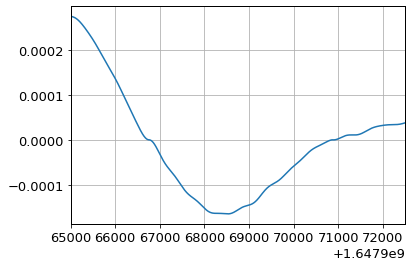

In [823]:
centered_abs_filtered -= y2
centered_abs_filtered[index[0][1]:index[0][2]] *= -1
plt.plot(sun_times[:20000], 2*centered_abs_filtered[:20000])
plt.xlim(65000+1.6479e9, 72500+1.6479e9)

In [824]:
ha = np.load('ha_sun_6hr.npy')
delta = 0.011622079794743386
λ = 0.02855166266666667

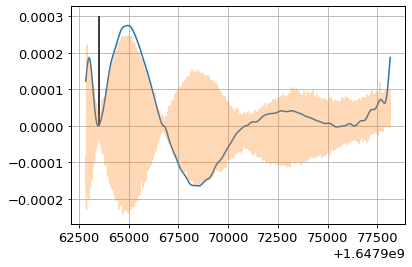

In [825]:
plt.plot(sun_times[:20000], 2*centered_abs_filtered[:20000])
plt.plot(sun_times[:20000], (sun_data - np.average(sun_data))[:20000], alpha=0.3)
plt.vlines(63500+1.6479e9, 0, 0.0003)

sun_data = sun_data[np.where(sun_times < 75000+1.6479e9)]
centered_abs_filtered = centered_abs_filtered[np.where(sun_times < 75000+1.6479e9)]
sun_times = sun_times[np.where(sun_times < 75000+1.6479e9)]
ha = ha[np.where(sun_times < 75000+1.6479e9)]

sun_data = sun_data[np.where(sun_times > 63500+1.6479e9)]
centered_abs_filtered = centered_abs_filtered[np.where(sun_times > 63500+1.6479e9)]
sun_times = sun_times[np.where(sun_times > 63500+1.6479e9)]
ha = ha[np.where(sun_times > 63500+1.6479e9)]


Text(0.5, 1.0, 'Processed Envelope')

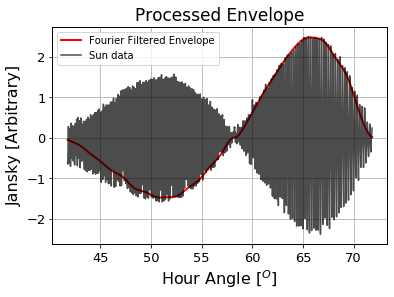

In [826]:
# val = con.c / (10.5e9 * u.Hz)
# λ = val.to(u.m).value
# # print("lambda", λ)

# L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 

# jds=ugradio.timing.julian_date(sun_times)
# alpha,delta =ugradio.coord.sunpos(jds[0])
# delta=(np.pi/180)*delta
# LSTs = ugradio.timing.lst(jds,lon=long)
# hs = LSTs - alpha*(np.pi/180)
# frac_time = len(sun_times)/23964
# ha = np.linspace(hs[0],(hs[0]+(15*6*frac_time)*(np.pi/180)),len(jds))
# print(ha[1])

ha = ha[:8000]
ha_degrees = [h * 180 / np.pi if h *180 / np.pi < 270 else 360 - h *180 / np.pi for h in ha]
sun_data = sun_data[:8000]
sun_times = sun_times[:8000]
centered_abs_filtered = centered_abs_filtered[:8000]

plt.plot(ha_degrees, 1.8*centered_abs_filtered*1e4, 'r-', lw=2,label="Fourier Filtered Envelope")
plt.plot(ha_degrees, (sun_data - np.average(sun_data))*1e4, 'k', alpha=0.7, label="Sun data")
plt.legend()
plt.xlabel('Hour Angle [$^O$]')
plt.ylabel('Jansky [Arbitrary]')
plt.title('Processed Envelope')
# plt.xlim(5.05, 5.5)
# plt.vlines(ha[8000], 0, 0.0003)
# print(len(sun_times), len(sun_times)/23964)


In [827]:
def bessel(ha, thetaR, A):
#     delta = 0
    d = 14.8035 #m 14.7106 or 14.8806
    u = d * np.cos(delta) * np.cos(ha) / λ
    x = 2 * np.pi * thetaR * u
    return A * scipy.special.j1(x) / x

In [828]:
p0 = [0.005, 0.1]
pars, cov = scipy.optimize.curve_fit(bessel, ha, centered_abs_filtered, p0)

In [829]:
print(pars)

[ 0.00402309 -0.0019281 ]


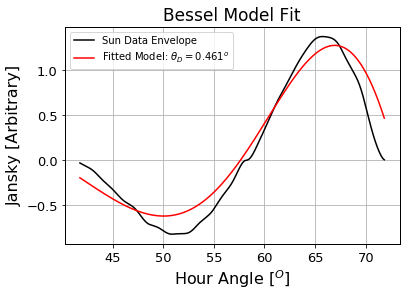

In [832]:
plt.plot(ha_degrees, centered_abs_filtered*1e4, 'k', label='Sun Data Envelope')
plt.plot(ha_degrees, bessel(ha, pars[0], pars[1])*1e4, 'r-', label=r'Fitted Model: $\theta_{D} = 0.461^o$')
plt.title('Bessel Model Fit')
plt.xlabel('Hour Angle [$^O$]')
plt.ylabel('Jansky [Arbitrary]')
plt.legend()

In [833]:
sun_diameter = pars[0] * 180 / np.pi * 2
print('sun diameter:', sun_diameter) 
print('Percent of expected value:', sun_diameter/(0.51) * 100)
# expected 0.53 degrees

sun diameter: 0.46101248580894255
Percent of expected value: 90.39460506057696


In [189]:
# .0039 radians is the radius

In [110]:
sun_data, sun_times = np.load("data/sun_6hr_again.npy")

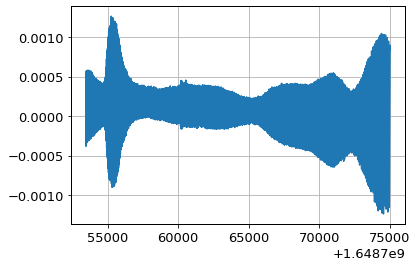

In [111]:
plt.plot(sun_times, sun_data)

In [112]:
delta = 0.07414875448150114
λ = 0.02855166266666667
ha = np.load('ha_sun_6hr_again.npy')

(0, 0.25)

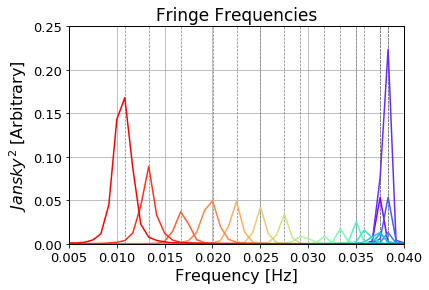

In [113]:
sun_splits, sun_freqs = split_data(sun_data, sun_times, 18)
colors = cm.rainbow(np.linspace(0, 1, len(sun_splits)))
n = len(sun_splits)
peaks = []
ha_peaks = []
for i in range(n):
    plt.plot(sun_freqs[i], sun_splits[i], color=colors[i], label=str(ha[len(sun_splits[i]) * i] * 180/np.pi)[:5])
    peak1, peak2 = scipy.signal.find_peaks(sun_splits[i], height=[0.001, 0.25])[0][0], scipy.signal.find_peaks(sun_splits[i], height=[0.001, 0.25])[0][-1]
    peaks.append(sun_freqs[i][peak2])
    peaks.append(sun_freqs[i][peak1])
    ha_peaks.append(ha[len(sun_splits[i]) * i])
    ha_peaks.append(ha[len(sun_splits[i]) * i])
    plt.vlines(sun_freqs[i][peak1], 0, 0.25, lw=0.5)
    plt.vlines(sun_freqs[i][peak2], 0, 0.25, color='gray',lw=0.7, ls='--')
# plt.legend(loc='upper left')
plt.xlabel("Frequency [Hz]")
plt.ylabel("$Jansky^2$ [Arbitrary]")
plt.title("Fringe Frequencies")
# plt.title("Fringe Frequency")
plt.xlim(0.005,0.04)
plt.ylim(0,0.25)

36 36


Text(0, 0.5, 'Frequency [Hz]')

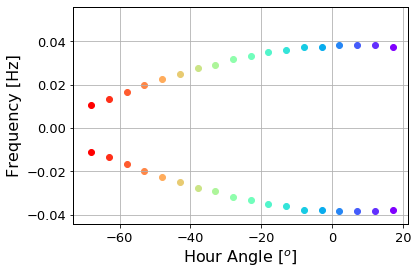

In [114]:
print(len(ha_peaks), len(peaks))
ha_peaks_degrees = [ha * 180 / np.pi if ha *180 / np.pi < 270 else 360 - ha *180 / np.pi for ha in ha_peaks]
for i in range(len(colors)):
    plt.scatter(ha_peaks_degrees[i*2], peaks[i*2], color=colors[i])
    plt.scatter(ha_peaks_degrees[i*2+1], peaks[i*2+1], color=colors[i])
plt.xlabel('Hour Angle [$ ^o$]')
plt.ylabel('Frequency [Hz]')

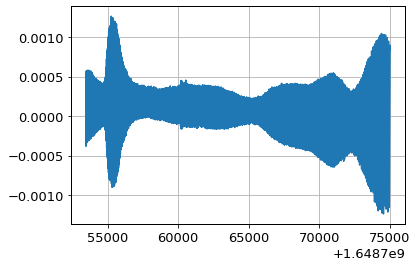

In [115]:
centered_abs_sun_data = np.abs(sun_data - np.average(sun_data))
plt.plot(sun_times, sun_data)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.1, 0.1)

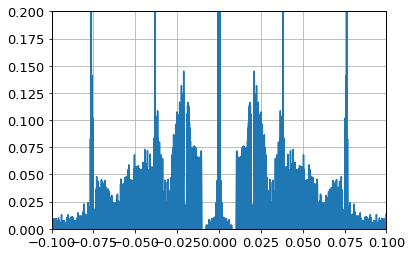

In [116]:
fft = np.fft.fftshift(np.fft.fft(centered_abs_sun_data))
freqs = freq(sun_times, np.mean(np.diff(sun_times)))
plt.plot(freqs, fft)
plt.ylim(0,.2)
plt.xlim(-0.1, 0.1)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.0025, 0.0025)

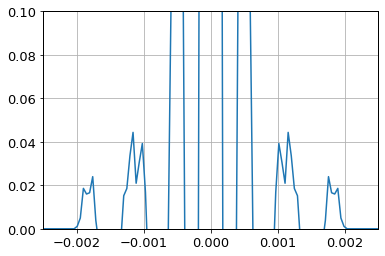

In [117]:
fft[np.where(freqs > 0.002)] = 0
fft[np.where(freqs < -0.002)] = 0
plt.plot(freqs, fft)
plt.ylim(0,0.1)
plt.xlim(-0.0025, 0.0025)

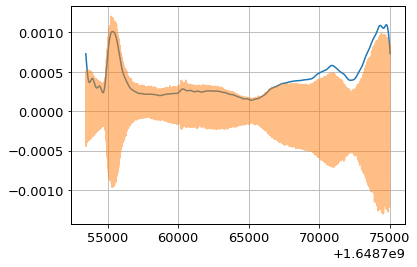

In [118]:
filtered_sun_data = np.fft.ifft(fft)


centered_abs_filtered = np.abs(filtered_sun_data - np.average(filtered_sun_data))
index = scipy.signal.argrelmin(centered_abs_filtered, order=2000)

minima = sun_times[index]

plt.plot(sun_times, 1.5*centered_abs_filtered)
plt.plot(sun_times, (sun_data - np.average(sun_data)), alpha=0.5)
# np.where(sun_times < )
# plt.xlim(65000+1.6479e9, 72500+1.6479e9)
# plt.vlines(66750+1.6479e9, 0,0.00035)
# plt.vlines(70800+1.6479e9, 0, 0.00035)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


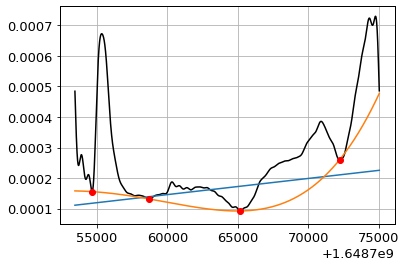

In [119]:
minima = sun_times[index] - sun_times[0]
minima_data = centered_abs_filtered[index]

plt.plot(sun_times, centered_abs_filtered, c='k')
plt.scatter(minima + sun_times[0], minima_data, c='r', zorder=5)

p1 = np.polyfit(minima, minima_data, deg=1)
y1 = np.polyval(p1, sun_times - sun_times[0])
plt.plot(sun_times, y1)

p2 = np.polyfit(minima, minima_data, deg=4)
y2 = np.polyval(p2, sun_times - sun_times[0])
plt.plot(sun_times, y2)

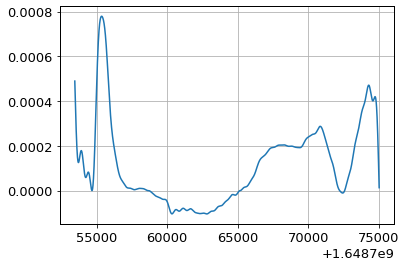

In [120]:
centered_abs_filtered -= y2
centered_abs_filtered[index[0][1] :index[0][2]] *= -1
plt.plot(sun_times, 1.5*centered_abs_filtered)
# plt.xlim(65000+1.6479e9, 72500+1.6479e9)

In [121]:
centered_abs_filtered = centered_abs_filtered[index[0][0]:index[0][-1]]

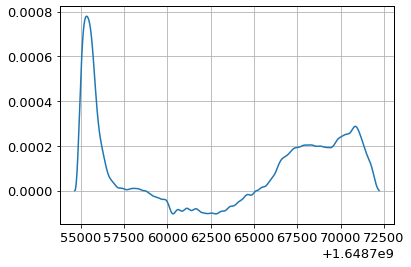

In [123]:
sun_times = sun_times[index[0][0]:index[0][-1]]
plt.plot(sun_times, 1.5*centered_abs_filtered)

In [125]:
ha = ha[index[0][0]:index[0][-1]]
p0 = [0.005, 0.1]
pars, cov = scipy.optimize.curve_fit(bessel, ha, centered_abs_filtered, p0)

[ 0.00553597 -0.00298625]


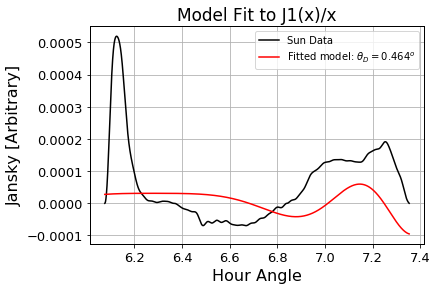

In [126]:
print(pars)
plt.plot(ha, centered_abs_filtered, 'k', label='Sun Data')
plt.plot(ha, bessel(ha, pars[0], pars[1]), 'r-', label=r'Fitted model: $\theta_{D} = 0.464^o$')
plt.title('Model Fit to J1(x)/x')
plt.xlabel('Hour Angle')
plt.ylabel('Jansky [Arbitrary]')
plt.legend()